Data set from Kaggle: 

https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance

In [ ]:
%pip install catboost matplotlib pandas scikit-learn kaggle optuna ipywidgets kaleido shap jupyterlab-rise


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#!dir ../../../home/vscode

In [3]:
import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)
    
    with open(config_dir / "kaggle.json", "w") as dst:
        with open("./kaggle.json", "r") as src:
            dst.write(src.read())

In [4]:
import os
import zipfile
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# dataset = "student-habits-vs-academic-performance"
# dataset_test = "jayaantanaath/student-habits-vs-academic-performance"
# download_folder = Path("data/student-habits-vs-academic-performance")
# zip_path = download_folder / "student-habits-vs-academic-performance.zip"
# download_folder.mkdir(parents=True, exist_ok=True)

# api.competition_download_files(dataset, path=str(download_folder))
# api.dataset_download_files(dataset_test, path=str(download_folder), unzip=True)

dataset_name = "jayaantanaath/student-habits-vs-academic-performance" #tutaj wpisuje baze
download_folder = Path("data/student-habits-vs-academic-performance") #tutaj bedzie folder w ktorym bedzie dane
download_folder.mkdir(parents=True, exist_ok=True)

api.dataset_download_files(dataset_name, path=str(download_folder), unzip=True)


# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(str(download_folder))
# os.remove(zip_path)

Dataset URL: https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance


In [5]:
!dir "./data/student-habits-vs-academic-performance"

 Volume in drive C has no label.
 Volume Serial Number is 1AC9-520E

 Directory of c:\Users\Magda\Desktop\MLOps_p1\data\student-habits-vs-academic-performance

17.05.2025  07:34    <DIR>          .
16.05.2025  12:45    <DIR>          ..
17.05.2025  07:34            73�663 student_habits_performance.csv
               1 File(s)         73�663 bytes
               2 Dir(s)  179�206�107�136 bytes free


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(download_folder / "student_habits_performance.csv")
# df_ids = df_train.pop("PassengerId")
#df.sample(10)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 521 to 78
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     200 non-null    object 
 1   age                            200 non-null    int64  
 2   gender                         200 non-null    object 
 3   study_hours_per_day            200 non-null    float64
 4   social_media_hours             200 non-null    float64
 5   netflix_hours                  200 non-null    float64
 6   part_time_job                  200 non-null    object 
 7   attendance_percentage          200 non-null    float64
 8   sleep_hours                    200 non-null    float64
 9   diet_quality                   200 non-null    object 
 10  exercise_frequency             200 non-null    int64  
 11  parental_education_level       184 non-null    object 
 12  internet_quality               200 non-null    object 

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 29 to 102
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     800 non-null    object 
 1   age                            800 non-null    int64  
 2   gender                         800 non-null    object 
 3   study_hours_per_day            800 non-null    float64
 4   social_media_hours             800 non-null    float64
 5   netflix_hours                  800 non-null    float64
 6   part_time_job                  800 non-null    object 
 7   attendance_percentage          800 non-null    float64
 8   sleep_hours                    800 non-null    float64
 9   diet_quality                   800 non-null    object 
 10  exercise_frequency             800 non-null    int64  
 11  parental_education_level       725 non-null    object 
 12  internet_quality               800 non-null    object 

In [21]:
y_train = df_train.pop("internet_quality")
X_train = df_train


In [22]:
y_test = df_test.pop("internet_quality")
X_test = df_test

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 29 to 102
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    800 non-null    int64  
 1   study_hours_per_day    800 non-null    float64
 2   social_media_hours     800 non-null    float64
 3   netflix_hours          800 non-null    float64
 4   attendance_percentage  800 non-null    float64
 5   sleep_hours            800 non-null    float64
 6   exercise_frequency     800 non-null    int64  
 7   mental_health_rating   800 non-null    int64  
 8   exam_score             800 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 62.5 KB


In [29]:
import joblib
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

outfolder = Path("results")
outfolder.mkdir(parents=True, exist_ok=True)

best_params_path = outfolder / "best_params.pkl"

if not best_params_path.is_file():
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
    
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3),
            "iterations": trial.suggest_int("iterations", 100, 300),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 100.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 1),
            "random_strength": trial.suggest_float("random_strength", 1e-5, 100.0, log=True)
        }
        model = CatBoostClassifier(**params, verbose=0)
        model.fit(X_train_opt, y_train_opt, eval_set=(X_val_opt, y_val_opt), early_stopping_rounds=50)
        return model.get_best_score()["validation"]["Logloss"]
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    
    joblib.dump(study.best_params, best_params_path)
    params = study.best_params
else:
    params = joblib.load(best_params_path)
print("Best Parameters:", params)

Best Parameters: {'depth': 9, 'learning_rate': 0.1989710549297809, 'iterations': 225, 'l2_leaf_reg': 5.203681083589466, 'bagging_temperature': 0.6748870052060675, 'random_strength': 0.27921747675539976}


In [44]:
params = {
    "loss_function": "MultiClass",  # jeśli masz >2 klasy
    "eval_metric": "Accuracy",
}

model = CatBoostClassifier(
    **params,
    verbose=True
)

data = Pool(X_train, y_train)

cv_results = cv(
    params=params,
    pool=data,
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
)

cv_results.to_csv(outfolder / "cv_results.csv", index=False)


Training on fold [0/5]
0:	learn: 0.4835681	test: 0.4347826	best: 0.4347826 (0)	total: 156ms	remaining: 2m 35s
1:	learn: 0.5054773	test: 0.4037267	best: 0.4347826 (0)	total: 158ms	remaining: 1m 18s
2:	learn: 0.5336463	test: 0.4161491	best: 0.4347826 (0)	total: 160ms	remaining: 53.1s
3:	learn: 0.5571205	test: 0.4658385	best: 0.4658385 (3)	total: 162ms	remaining: 40.3s
4:	learn: 0.5790297	test: 0.4409938	best: 0.4658385 (3)	total: 164ms	remaining: 32.6s
5:	learn: 0.5962441	test: 0.4037267	best: 0.4658385 (3)	total: 166ms	remaining: 27.5s
6:	learn: 0.5978091	test: 0.4161491	best: 0.4658385 (3)	total: 169ms	remaining: 24s
7:	learn: 0.5899844	test: 0.4037267	best: 0.4658385 (3)	total: 169ms	remaining: 21s
8:	learn: 0.5868545	test: 0.4099379	best: 0.4658385 (3)	total: 172ms	remaining: 18.9s
9:	learn: 0.5884194	test: 0.4161491	best: 0.4658385 (3)	total: 173ms	remaining: 17.2s
10:	learn: 0.5978091	test: 0.4347826	best: 0.4658385 (3)	total: 175ms	remaining: 15.8s
11:	learn: 0.5993740	test: 0.453

In [ ]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-F1-mean"], mode="lines", name="Mean F1 Score", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-F1-mean"]+cv_results["test-F1-std"], 
                     cv_results["test-F1-mean"]-cv_results["test-F1-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Performance Score",
    template="plotly_white",
    yaxis=dict(range=[0.5, 1])
)

fig.show()

fig.write_image(outfolder / "test_f1.png")

In [15]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-Logloss-mean"], mode="lines", name="Mean logloss", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-Logloss-mean"]+cv_results["test-Logloss-std"], 
                     cv_results["test-Logloss-mean"]-cv_results["test-Logloss-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Logloss",
    template="plotly_white"
)

fig.show()

fig.write_image(outfolder / "test_logloss.png")

In [34]:
model.fit(
    X_train,
    y_train,
    verbose_eval=50,
    early_stopping_rounds=50,
    use_best_model=False,
    plot=True
)

model.save_model(outfolder / 'tudent_habits_performance.cbm')
joblib.dump(params, outfolder / 'model_params_test1.pkl')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: catboost/private/libs/target/target_converter.cpp:410: Target with classes must contain only 2 unique values for binary classification

In [42]:
#df_test = pd.read_csv(download_folder / "test.csv")

In [43]:
model.predict(df_test)

array(['No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No

In [44]:
preds = model.predict(df_test[X_train.columns])

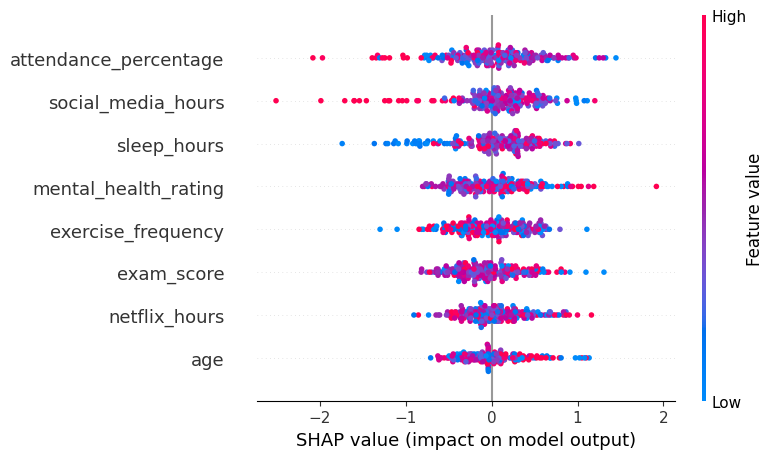

In [45]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test)

shap.summary_plot(shap_values, df_test, show=False)
plt.savefig(outfolder / "test_shap_overall.png")

In [46]:
df_test["target"] = preds
df_test.to_csv(outfolder / "predictions.csv", index=False)